100%|██████████| 26.4M/26.4M [00:04<00:00, 5.74MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 177kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [05:28<00:00, 13.5kB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw

Epoch: 1 Average loss: 283.7918
Epoch: 2 Average loss: 255.8656
Epoch: 3 Average loss: 250.3932
Epoch: 4 Average loss: 247.7268
Epoch: 5 Average loss: 246.1309
Epoch: 6 Average loss: 245.0354
Epoch: 7 Average loss: 244.2115
Epoch: 8 Average loss: 243.6215
Epoch: 9 Average loss: 243.1278
Epoch: 10 Average loss: 242.6183


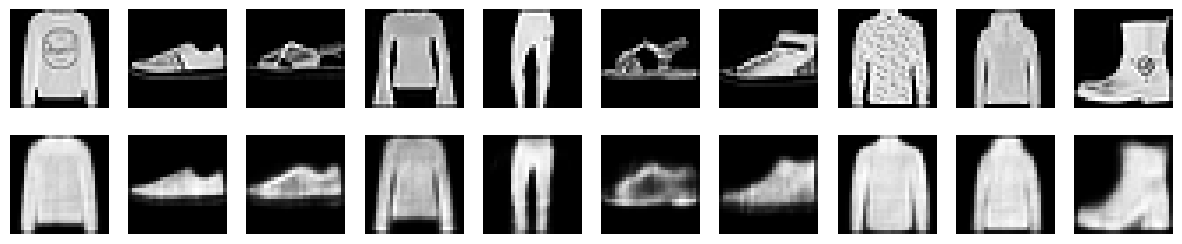

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the VAE model
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder: Convert input images into a 400-dimensional hidden vector
        self.fc1 = nn.Linear(28 * 28, 400)
        # Two linear layers for computing mean (mu) and log variance (logvar) of the latent variable
        self.fc21 = nn.Linear(400, 20)  # Mean (mu)
        self.fc22 = nn.Linear(400, 20)  # Log variance (logvar)

        # Decoder: Reconstructs original images from the latent variable
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    # Reparameterization trick: z = mu + sigma * epsilon, where epsilon ~ N(0,1)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        # x: [batch_size, 1, 28, 28] -> [batch_size, 784]
        mu, logvar = self.encode(x.view(-1, 28 * 28))
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function: Sum of reconstruction loss and KL divergence term
def vae_loss(recon_x, x, mu, logvar):
    # Reconstruction loss: Measures the difference between the original and reconstructed images
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    # KL divergence: Measures how much q(z|x) deviates from the prior distribution p(z) ~ N(0, I)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Dataset and DataLoader setup
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Model and optimizer configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 10
model.train()
for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch: {epoch+1} Average loss: {avg_loss:.4f}')

# Reconstruct images using the trained model
test_dataset = datasets.FashionMNIST('./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=True)
model.eval()
with torch.no_grad():
    test_data, _ = next(iter(test_loader))
    test_data = test_data.to(device)
    recon_data, _, _ = model(test_data)
    recon_data = recon_data.view(-1, 1, 28, 28).cpu()

# Visualizing original vs. reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    axes[0, i].imshow(test_data[i].cpu().squeeze(), cmap='gray')
    axes[0, i].axis('off')
    axes[1, i].imshow(recon_data[i].squeeze(), cmap='gray')
    axes[1, i].axis('off')
plt.show()


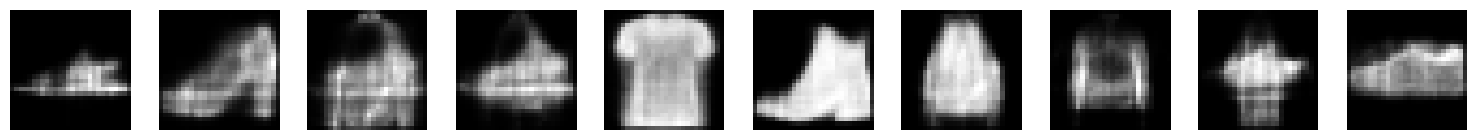

In [2]:
# Image Generation
with torch.no_grad():
    # random latent vector
    random_z = torch.randn(10, 20).to(device)

    # decoding
    generated = model.decode(random_z)
    generated = generated.view(-1, 1, 28, 28).cpu()

    # visualization
    plt.figure(figsize=(15, 1.5))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated[i].squeeze().numpy(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('vae_generated.png')  # saving file
    plt.show()